In [1]:
#MAT 254 - University of Bergen
#Compare TPFA and MPFA

import numpy as np
import scipy
import sympy

import porepy as pp

N =  4


/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


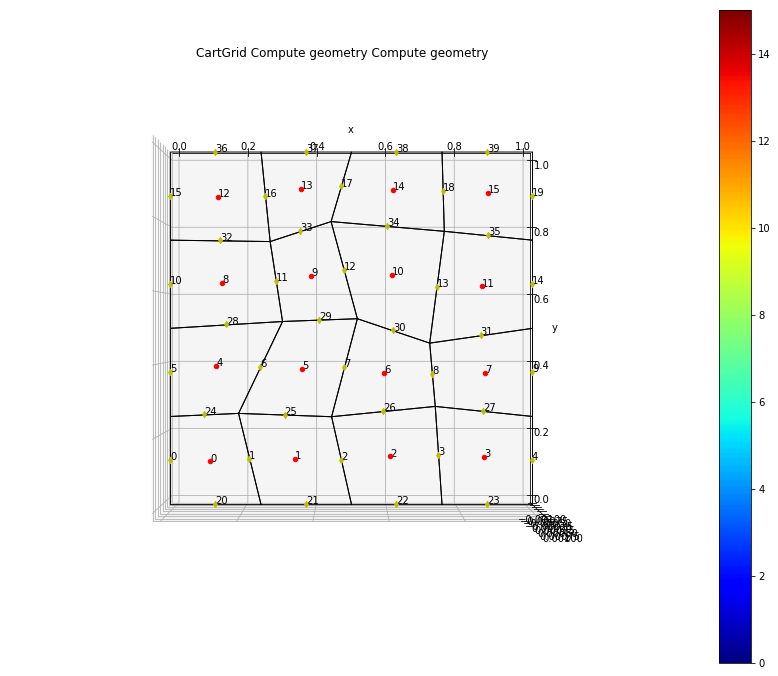

pressure error TPFA = 0.07811162809735654
flux error TPFA = 0.06914113829274816
pressure error MPFA = 0.06787113418678607
flux error MPFA = 0.035365950589424815
done


In [71]:
# 1. Input and Creation of the grid
Nx = Ny = 4
print("N = ", Nx)
Lx = Ly = 1
phys_dims = [Lx,Ly]
g = pp.CartGrid([Nx, Ny], phys_dims)
g.compute_geometry()
# Define boundary faces
top_faces = np.ravel(np.argwhere(g.face_centers[1] > Ly - 1e-10))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
lef_faces = np.ravel(np.argwhere(g.face_centers[0] < 1e-10))
rig_faces = np.ravel(np.argwhere(g.face_centers[0] > Lx - 1e-10))

pert = 0.5

if pert > 0:
    top_nodes = np.ravel(np.argwhere(g.nodes[1] > Ly - 1e-10))
    bot_nodes = np.ravel(np.argwhere(g.nodes[1] < 1e-10))
    lef_nodes = np.ravel(np.argwhere(g.nodes[0] < 1e-10))
    rig_nodes = np.ravel(np.argwhere(g.nodes[0] > Lx - 1e-10))
    
    move = np.ones(g.num_nodes)
    move[top_nodes] = 0
    move[bot_nodes] = 0
    move[lef_nodes] = 0
    move[rig_nodes] = 0

    
    dx = 1/Nx
    rand = np.vstack((np.random.rand(g.dim, g.num_nodes), np.repeat(0., g.num_nodes)))
    g.nodes += pert * dx * (rand - 0.5)*move
    if g.dim == 2:
        g.nodes[2, :] = 0
    g.compute_geometry()
    

xc = g.cell_centers
xf = g.face_centers
xn = g.nodes
cell_id = np.arange(g.num_cells)
bound_faces = g.get_all_boundary_faces()
pp.plot_grid(g, cell_value=cell_id, info='cf', alpha=0.0, figsize=(15,12))
# Analytical solution
x, y = sympy.symbols('x y')
p = 2*x**3*y**2 #linear pressure should give 0 error
pi = sympy.lambdify((x, y), p, 'numpy')
dpx = sympy.diff(p, x)
dpy = sympy.diff(p, y)
dpxi = sympy.lambdify((x, y), dpx, 'numpy')
dpyi = sympy.lambdify((x, y), dpy, 'numpy')
rhs = -sympy.diff(dpx, x) - sympy.diff(dpy, y)
fi = sympy.lambdify((x, y), rhs, 'numpy')

##### NEW EXACT SOL
#x, y = sympy.symbols('x y')
#p = 2*x**3*y**2 #linear pressure should give 0 error
#pi = sympy.lambdify((x, y), p, 'numpy')

# 1st Derivative
#dpx = sympy.diff(p, x)
#dpy = sympy.diff(p, y)
#dpxi = sympy.lambdify((x, y), dpx, 'numpy')
#dpyi = sympy.lambdify((x, y), dpy, 'numpy')

# Flux for a permeability, K = 0.5 * [1, -1]
#                                    [-1, 1]
#qx_ = -(1/2) * (dpx - dpy)
#qy_ = -(1/2) * (-dpx + dpy)

# div q:
#rhs = sympy.diff(qx_, x) + sympy.diff(qy_, y)
#fi = sympy.lambdify((x, y), rhs, 'numpy')
######

pc_ex = pi(xc[0], xc[1])
pf_ex = pi(xf[0], xf[1])
flux_ex = -(g.face_normals[0,:] * dpxi(xf[0], xf[1]) + g.face_normals[1,:] * dpyi(xf[0], xf[1]))

# Permeability

perm_xx = 1
perm_yy = 1
perm_xy = 0
k_xx = perm_xx * np.ones(g.num_cells)
k_xy = perm_xy * np.ones(g.num_cells)
k_yy = perm_yy * np.ones(g.num_cells)
k = pp.SecondOrderTensor(k_xx, kyy=k_yy, kxy=k_xy)
# Unitary scalar source already integrated in each cell

fc = fi(xc[0, :], xc[1, :])*g.cell_volumes

#### Boundary conditions - case 2
# Define boundary type: Dirichlet at left and right, Neunam at top and bottom

neuman = np.block([bot_faces, top_faces])
dirich = np.block([lef_faces, rig_faces])

#neuman = np.block([top_faces])
#dirich = np.block([lef_faces, rig_faces, bot_faces, top_faces])


if len(neuman) == 0:
    bound_faces = np.block([dirich])
    labels = np.array(['dir']*bound_faces.size)
    p_bound = np.zeros(g.num_faces)
    p_bound[dirich] = pf_ex[dirich]
else:
    bound_faces = np.block([neuman,dirich])
    labels = np.array(['dir']*bound_faces.size)
    labels[0:len(neuman)] = 'neu' 
    p_bound = np.zeros(g.num_faces)
    p_bound[dirich] = pf_ex[dirich]
    p_bound[neuman] = flux_ex[neuman]
    
bound_condition = pp.BoundaryCondition(g, bound_faces, labels)
# Collect all parameters in a dictionary
parameters = {"second_order_tensor": k, "bc": bound_condition, "bc_values": p_bound}
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)
matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][data_key]
######## TPFA
# Two-point flux approximation - compute pressure
tpfa_solver = pp.Tpfa(data_key)
tpfa_solver.discretize(g, data)
A, b_flow = tpfa_solver.assemble_matrix_rhs(g, data)
p_tpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
# Two-point flux approximation - compute flux
flux = matrix_dictionary["flux"]
bound_flux = matrix_dictionary["bound_flux"]
div = pp.fvutils.scalar_divergence(g)
flux_tpfa = flux * p_tpfa + bound_flux * p_bound
######## MPFA
# Multi-point flux approximation - compute pressure
mpfa_solver = pp.Mpfa(data_key)
mpfa_solver.discretize(g, data)
A, b_flow = mpfa_solver.assemble_matrix_rhs(g, data)
p_mpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
# Multi-point flux approximation - compute flux
flux  = matrix_dictionary["flux"]
bound_flux = matrix_dictionary["bound_flux"]
flux_mpfa = flux * p_mpfa + bound_flux * p_bound

# Exact solution

p_diff_tpfa = p_tpfa - pc_ex  
flux_diff_tpfa = flux_tpfa - flux_ex

p_diff_mpfa = p_mpfa - pc_ex  
flux_diff_mpfa = flux_mpfa - flux_ex

p_err_tpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_tpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
flux_err_tpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_tpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))
     
p_err_mpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_mpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
flux_err_mpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_mpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))
        
print('pressure error TPFA =', p_err_tpfa)
print('flux error TPFA =', flux_err_tpfa)

print('pressure error MPFA =', p_err_mpfa)
print('flux error MPFA =', flux_err_mpfa)

F_n = flux_mpfa * g.face_normals
#pp.plot_grid(g, vector_value=F_n, figsize=(15, 12))



print('done')

# Isotropic permeability
Use $K = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}$

In [48]:
#MAT 254 - University of Bergen
#Compare TPFA and MPFA

def iso_perm(N):
    # 1. Input and Creation of the grid
    Nx = Ny = N
    print("N = ", Nx)
    Lx = Ly = 1
    phys_dims = [Lx,Ly]
    g = pp.CartGrid([Nx, Ny], phys_dims)
    g.compute_geometry()
    # Define boundary faces
    top_faces = np.ravel(np.argwhere(g.face_centers[1] > Ly - 1e-10))
    bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
    lef_faces = np.ravel(np.argwhere(g.face_centers[0] < 1e-10))
    rig_faces = np.ravel(np.argwhere(g.face_centers[0] > Lx - 1e-10))

    pert = 0.5

    if pert > 0:
        top_nodes = np.ravel(np.argwhere(g.nodes[1] > Ly - 1e-10))
        bot_nodes = np.ravel(np.argwhere(g.nodes[1] < 1e-10))
        lef_nodes = np.ravel(np.argwhere(g.nodes[0] < 1e-10))
        rig_nodes = np.ravel(np.argwhere(g.nodes[0] > Lx - 1e-10))

        move = np.ones(g.num_nodes)
        move[top_nodes] = 0
        move[bot_nodes] = 0
        move[lef_nodes] = 0
        move[rig_nodes] = 0


        dx = 1/Nx
        rand = np.vstack((np.random.rand(g.dim, g.num_nodes), np.repeat(0., g.num_nodes)))
        g.nodes += pert * dx * (rand - 0.5)*move
        if g.dim == 2:
            g.nodes[2, :] = 0
        g.compute_geometry()

    # Permeability
    perm_xx = 1
    perm_yy = 2
    perm_xy = 0
    k_xx = perm_xx * np.ones(g.num_cells)
    k_xy = perm_xy * np.ones(g.num_cells)
    k_yy = perm_yy * np.ones(g.num_cells)
    k = pp.SecondOrderTensor(k_xx, kyy=k_yy, kxy=k_xy)

    # Analytical stuff
    xc = g.cell_centers
    xf = g.face_centers
    xn = g.nodes
    cell_id = np.arange(g.num_cells)
    bound_faces = g.get_all_boundary_faces()
    #pp.plot_grid(g, cell_value=cell_id, info='cf', alpha=0.0, figsize=(8,8))
    # Analytical solution
    x, y = sympy.symbols('x y')
    p = 2*x**3*y**2 #linear pressure should give 0 error
    pi = sympy.lambdify((x, y), p, 'numpy')

    # 1st Derivative
    dpx = sympy.diff(p, x)
    dpy = sympy.diff(p, y)
    dpxi = sympy.lambdify((x, y), dpx, 'numpy')
    dpyi = sympy.lambdify((x, y), dpy, 'numpy')

    # Flux for a permeability, K = [Kxx, Kxy]
    #                              [Kxy, Kyy]

    # div q:
    rhs = - perm_xx*sympy.diff(dpx, x) - perm_xy*sympy.diff(dpy, x) - perm_xy*sympy.diff(dpx, x) - perm_yy*sympy.diff(dpy, x)
    rhs = sympy.diff(qx_, x) + sympy.diff(qy_, y)
    fi = sympy.lambdify((x, y), rhs, 'numpy')

    pc_ex = pi(xc[0], xc[1])
    pf_ex = pi(xf[0], xf[1])

    flux_ex0 = - g.face_normals[0,:] * (perm_xx * dpxi(xf[0], xf[1]) + perm_xy * dpyi(xf[0], xf[1]))
    flux_ex1 = - g.face_normals[1,:] * (perm_xy * dpxi(xf[0], xf[1]) + perm_yy * dpyi(xf[0], xf[1]))

    flux_ex = flux_ex0 + flux_ex1


    # Unitary scalar source already integrated in each cell

    fc = fi(xc[0, :], xc[1, :])*g.cell_volumes

    #### Boundary conditions - case 2
    # Define boundary type: Dirichlet at left and right, Neunam at top and bottom

    neuman = np.block([bot_faces, top_faces])
    dirich = np.block([lef_faces, rig_faces])

    #neuman = np.block([top_faces])
    #dirich = np.block([lef_faces, rig_faces, bot_faces, top_faces])


    if len(neuman) == 0:
        bound_faces = np.block([dirich])
        labels = np.array(['dir']*bound_faces.size)
        p_bound = np.zeros(g.num_faces)
        p_bound[dirich] = pf_ex[dirich]
    else:
        bound_faces = np.block([neuman,dirich])
        labels = np.array(['dir']*bound_faces.size)
        labels[0:len(neuman)] = 'neu' 
        p_bound = np.zeros(g.num_faces)
        p_bound[dirich] = pf_ex[dirich]
        p_bound[neuman] = flux_ex[neuman]

    bound_condition = pp.BoundaryCondition(g, bound_faces, labels)
    # Collect all parameters in a dictionary
    parameters = {"second_order_tensor": k, "bc": bound_condition, "bc_values": p_bound}
    data_key = "flow"
    data = pp.initialize_default_data(g, {}, data_key, parameters)
    matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][data_key]
    ######## TPFA
    # Two-point flux approximation - compute pressure
    tpfa_solver = pp.Tpfa(data_key)
    tpfa_solver.discretize(g, data)
    A, b_flow = tpfa_solver.assemble_matrix_rhs(g, data)
    p_tpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
    # Two-point flux approximation - compute flux
    flux = matrix_dictionary["flux"]
    bound_flux = matrix_dictionary["bound_flux"]
    div = pp.fvutils.scalar_divergence(g)
    flux_tpfa = flux * p_tpfa + bound_flux * p_bound
    ######## MPFA
    # Multi-point flux approximation - compute pressure

    # Inverter:
    data[pp.PARAMETERS][data_key]['mpfa_inverter'] = 'python'

    mpfa_solver = pp.Mpfa(data_key)
    mpfa_solver.discretize(g, data)
    A, b_flow = mpfa_solver.assemble_matrix_rhs(g, data)
    p_mpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
    # Multi-point flux approximation - compute flux
    flux  = matrix_dictionary["flux"]
    bound_flux = matrix_dictionary["bound_flux"]
    flux_mpfa = flux * p_mpfa + bound_flux * p_bound

    # Exact solution

    p_diff_tpfa = p_tpfa - pc_ex  
    flux_diff_tpfa = flux_tpfa - flux_ex

    p_diff_mpfa = p_mpfa - pc_ex  
    flux_diff_mpfa = flux_mpfa - flux_ex

    p_err_tpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_tpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
    flux_err_tpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_tpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))

    p_err_mpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_mpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
    flux_err_mpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_mpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))

    print('pressure error TPFA =', p_err_tpfa)
    print('flux error TPFA =', flux_err_tpfa)

    print('pressure error MPFA =', p_err_mpfa)
    print('flux error MPFA =', flux_err_mpfa)

    F_n = flux_mpfa * g.face_normals
    #pp.plot_grid(g, vector_value=F_n, figsize=(15, 12))
    #pp.plot_grid(g, p_mpfa, figsize=(15, 12))
    
    return p_err_tpfa, flux_err_tpfa, p_err_mpfa, flux_err_mpfa


    print('done')

In [51]:
N=[4,8,16,32,64]

p_err_tpfa = np.ones(len(N))
flux_err_tpfa = np.ones(len(N))
p_err_mpfa = np.ones(len(N))
flux_err_mpfa = np.ones(len(N))

for i, n in enumerate(N):
    p_err_tpfa[i], flux_err_tpfa[i], p_err_mpfa[i], flux_err_mpfa[i] = iso_perm(n)

N =  4
pressure error TPFA = 0.10127441086446058
flux error TPFA = 0.08443454382106667
pressure error MPFA = 0.06336925060149241
flux error MPFA = 0.034725983122999855
N =  8
pressure error TPFA = 0.05063107159895056
flux error TPFA = 0.17644807746555197
pressure error MPFA = 0.01721649032194464
flux error MPFA = 0.015201749634081897
N =  16
pressure error TPFA = 0.024236094468846916
flux error TPFA = 0.1282593221748513
pressure error MPFA = 0.0041879840220370125
flux error MPFA = 0.005117771328098608
N =  32
pressure error TPFA = 0.014999457064879327
flux error TPFA = 0.14440619624640458
pressure error MPFA = 0.001078555669089127
flux error MPFA = 0.0024951563253668638
N =  64
pressure error TPFA = 0.014258514830185582
flux error TPFA = 0.15748636482481307
pressure error MPFA = 0.0002677175468612707
flux error MPFA = 0.0012615504822335807


In [65]:
def r(p1, p0):
    return np.abs(np.log(p1/p0)/np.log(2))

def rate_for(lst):
    rates = np.zeros(len(lst)-1)
    for i, _ in enumerate(lst[:-1]):
        rates[i] = r(lst[i+1], lst[i])
    return rates

In [66]:
# TPFA p:
rate_for(p_err_tpfa)

array([1.00017477, 1.06286578, 0.69224695, 0.07308656])

In [67]:
# MPFA p:
rate_for(p_err_mpfa)

array([1.87999188, 2.03946323, 1.9571553 , 2.01031704])

In [68]:
# TPFA q:
rate_for(flux_err_tpfa)

array([1.06333845, 0.46018002, 0.17106896, 0.12509428])

In [69]:
# MPFA q:
rate_for(flux_err_mpfa)

array([1.19177816, 1.57064979, 1.03638548, 0.98393227])

# Rotated K tensor
Rotate by 45 degrees

N =  8
pressure error TPFA = 0.3447791251110548
flux error TPFA = 0.3740701341554216
pressure error MPFA = 0.49830047069615513
flux error MPFA = 0.3188532164712816


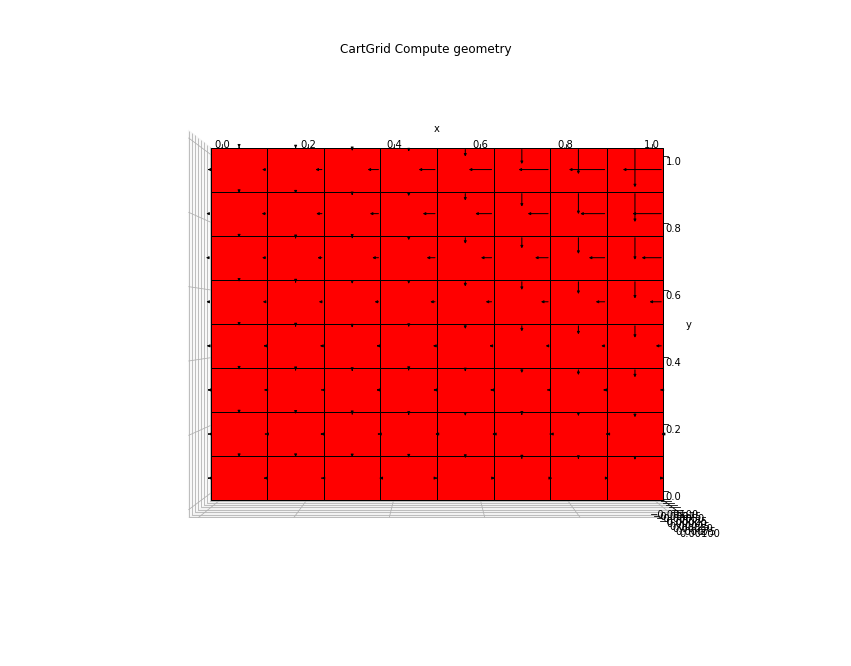

done


In [35]:
#MAT 254 - University of Bergen
#Compare TPFA and MPFA

# 1. Input and Creation of the grid
Nx = Ny = 8
print("N = ", Nx)
Lx = Ly = 1
phys_dims = [Lx,Ly]
g = pp.CartGrid([Nx, Ny], phys_dims)
g.compute_geometry()
# Define boundary faces
top_faces = np.ravel(np.argwhere(g.face_centers[1] > Ly - 1e-10))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
lef_faces = np.ravel(np.argwhere(g.face_centers[0] < 1e-10))
rig_faces = np.ravel(np.argwhere(g.face_centers[0] > Lx - 1e-10))

pert = 0

if pert > 0:
    top_nodes = np.ravel(np.argwhere(g.nodes[1] > Ly - 1e-10))
    bot_nodes = np.ravel(np.argwhere(g.nodes[1] < 1e-10))
    lef_nodes = np.ravel(np.argwhere(g.nodes[0] < 1e-10))
    rig_nodes = np.ravel(np.argwhere(g.nodes[0] > Lx - 1e-10))
    
    move = np.ones(g.num_nodes)
    move[top_nodes] = 0
    move[bot_nodes] = 0
    move[lef_nodes] = 0
    move[rig_nodes] = 0

    
    dx = 1/Nx
    rand = np.vstack((np.random.rand(g.dim, g.num_nodes), np.repeat(0., g.num_nodes)))
    g.nodes += pert * dx * (rand - 0.5)*move
    if g.dim == 2:
        g.nodes[2, :] = 0
    g.compute_geometry()

# Permeability
perm_xx = 3/2
perm_yy = 3/2
perm_xy = 1/2
k_xx = perm_xx * np.ones(g.num_cells)
k_xy = perm_xy * np.ones(g.num_cells)
k_yy = perm_yy * np.ones(g.num_cells)
k = pp.SecondOrderTensor(k_xx, kyy=k_yy, kxy=k_xy)

# Analytical stuff
xc = g.cell_centers
xf = g.face_centers
xn = g.nodes
cell_id = np.arange(g.num_cells)
bound_faces = g.get_all_boundary_faces()
#pp.plot_grid(g, cell_value=cell_id, info='cf', alpha=0.0, figsize=(8,8))
# Analytical solution
x, y = sympy.symbols('x y')
p = 2*x**3*y**2 #linear pressure should give 0 error
pi = sympy.lambdify((x, y), p, 'numpy')

# 1st Derivative
dpx = sympy.diff(p, x)
dpy = sympy.diff(p, y)
dpxi = sympy.lambdify((x, y), dpx, 'numpy')
dpyi = sympy.lambdify((x, y), dpy, 'numpy')

# Flux for a permeability, K = [Kxx, Kxy]
#                              [Kxy, Kyy]

# div q:
rhs = - perm_xx*sympy.diff(dpx, x) - perm_xy*sympy.diff(dpy, x) - perm_xy*sympy.diff(dpx, x) - perm_yy*sympy.diff(dpy, x)
rhs = sympy.diff(qx_, x) + sympy.diff(qy_, y)
fi = sympy.lambdify((x, y), rhs, 'numpy')

pc_ex = pi(xc[0], xc[1])
pf_ex = pi(xf[0], xf[1])

flux_ex0 = - g.face_normals[0,:] * (perm_xx * dpxi(xf[0], xf[1]) + perm_xy * dpyi(xf[0], xf[1]))
flux_ex1 = - g.face_normals[1,:] * (perm_xy * dpxi(xf[0], xf[1]) + perm_yy * dpyi(xf[0], xf[1]))

flux_ex = flux_ex0 + flux_ex1


# Unitary scalar source already integrated in each cell

fc = fi(xc[0, :], xc[1, :])*g.cell_volumes

#### Boundary conditions - case 2
# Define boundary type: Dirichlet at left and right, Neunam at top and bottom

neuman = np.block([bot_faces, top_faces])
dirich = np.block([lef_faces, rig_faces])

#neuman = np.block([top_faces])
#dirich = np.block([lef_faces, rig_faces, bot_faces, top_faces])


if len(neuman) == 0:
    bound_faces = np.block([dirich])
    labels = np.array(['dir']*bound_faces.size)
    p_bound = np.zeros(g.num_faces)
    p_bound[dirich] = pf_ex[dirich]
else:
    bound_faces = np.block([neuman,dirich])
    labels = np.array(['dir']*bound_faces.size)
    labels[0:len(neuman)] = 'neu' 
    p_bound = np.zeros(g.num_faces)
    p_bound[dirich] = pf_ex[dirich]
    p_bound[neuman] = flux_ex[neuman]
    
bound_condition = pp.BoundaryCondition(g, bound_faces, labels)
# Collect all parameters in a dictionary
parameters = {"second_order_tensor": k, "bc": bound_condition, "bc_values": p_bound}
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)
matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][data_key]
######## TPFA
# Two-point flux approximation - compute pressure
tpfa_solver = pp.Tpfa(data_key)
tpfa_solver.discretize(g, data)
A, b_flow = tpfa_solver.assemble_matrix_rhs(g, data)
p_tpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
# Two-point flux approximation - compute flux
flux = matrix_dictionary["flux"]
bound_flux = matrix_dictionary["bound_flux"]
div = pp.fvutils.scalar_divergence(g)
flux_tpfa = flux * p_tpfa + bound_flux * p_bound
######## MPFA
# Multi-point flux approximation - compute pressure

# Inverter:
data[pp.PARAMETERS][data_key]['mpfa_inverter'] = 'python'

mpfa_solver = pp.Mpfa(data_key)
mpfa_solver.discretize(g, data)
A, b_flow = mpfa_solver.assemble_matrix_rhs(g, data)
p_mpfa = scipy.sparse.linalg.spsolve(A, b_flow + fc)
# Multi-point flux approximation - compute flux
flux  = matrix_dictionary["flux"]
bound_flux = matrix_dictionary["bound_flux"]
flux_mpfa = flux * p_mpfa + bound_flux * p_bound

# Exact solution

p_diff_tpfa = p_tpfa - pc_ex  
flux_diff_tpfa = flux_tpfa - flux_ex

p_diff_mpfa = p_mpfa - pc_ex  
flux_diff_mpfa = flux_mpfa - flux_ex

p_err_tpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_tpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
flux_err_tpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_tpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))
     
p_err_mpfa = (np.sqrt(np.sum(g.cell_volumes * (p_diff_mpfa)**2))/np.sqrt(np.sum(g.cell_volumes * pc_ex**2)))
flux_err_mpfa = (np.sqrt(np.sum((g.face_areas ** g.dim) * flux_diff_mpfa**2))/np.sqrt(np.sum((g.face_areas ** g.dim) * flux_ex**2)))
        
print('pressure error TPFA =', p_err_tpfa)
print('flux error TPFA =', flux_err_tpfa)

print('pressure error MPFA =', p_err_mpfa)
print('flux error MPFA =', flux_err_mpfa)

F_n = flux_mpfa * g.face_normals
pp.plot_grid(g, vector_value=F_n, figsize=(15, 12))
#pp.plot_grid(g, p_mpfa, figsize=(15, 12))



print('done')

N =  4
pressure error TPFA = 0.34303665026757524
flux error TPFA = 0.39276959256583066
pressure error MPFA = 0.49513369315778477
flux error MPFA = 0.33623238795254584
done
N =  8
pressure error TPFA = 0.3447791251110548
flux error TPFA = 0.3740701341554216
pressure error MPFA = 0.49830047069615513
flux error MPFA = 0.3188532164712816
done
N =  16
pressure error TPFA = 0.34517470487696283
flux error TPFA = 0.3636351727128191
pressure error MPFA = 0.4978527832022735
flux error MPFA = 0.31104452241724156
done
N =  32
pressure error TPFA = 0.34527922226470736
flux error TPFA = 0.3574329270388515
pressure error MPFA = 0.4974192899588823
flux error MPFA = 0.3072374490686794
done
